# normal_model

## time pyd_data

## 原始数据读取

In [1]:
import pandas as pd

# ===================== 1️⃣ CWT 路径 =====================
cwt_train_csv = "/home/charles/HZU/Data_processed/my_CIL_V1/KAIST/KAIST_CWT/train/train_CWT.csv"
cwt_val_csv   = "/home/charles/HZU/Data_processed/my_CIL_V1/KAIST/KAIST_CWT/val/val_CWT.csv"
cwt_test_csv  = "/home/charles/HZU/Data_processed/my_CIL_V1/KAIST/KAIST_CWT/test/test_CWT.csv"

# ===================== 2️⃣ current&temp（已对齐）路径 =====================
ct_root = "/home/charles/HZU/Data_processed/HSML/KAIST/current&temp_raw_wl_5000/aligned_with_CWT"

ct_train_csv = f"{ct_root}/train_current&temp.csv"
ct_val_csv   = f"{ct_root}/val_current&temp.csv"
ct_test_csv  = f"{ct_root}/test_current&temp.csv"

# ===================== 3️⃣ 读取 =====================
cwt_train_df = pd.read_csv(cwt_train_csv)
cwt_val_df   = pd.read_csv(cwt_val_csv)
cwt_test_df  = pd.read_csv(cwt_test_csv)

ct_train_df  = pd.read_csv(ct_train_csv)
ct_val_df    = pd.read_csv(ct_val_csv)
ct_test_df   = pd.read_csv(ct_test_csv)

# ===================== 4️⃣ 基本信息检查 =====================
print("=== CWT ===")
print("Train:", cwt_train_df.shape)
print("Val  :", cwt_val_df.shape)
print("Test :", cwt_test_df.shape)

print("\n=== Current & Temp (Aligned) ===")
print("Train:", ct_train_df.shape)
print("Val  :", ct_val_df.shape)
print("Test :", ct_test_df.shape)


=== CWT ===
Train: (1639, 126)
Val  : (272, 126)
Test : (819, 126)

=== Current & Temp (Aligned) ===
Train: (1639, 7)
Val  : (272, 7)
Test : (819, 7)


## 六个集图结构搭建，CWT的数据已经进行过列归一化

In [2]:
# ===================== 单cell：CT列归一化 -> 六个数据集构图并保存到 MMFD =====================
import os
import numpy as np
import pandas as pd
import torch

# --------------------- 输出目录 ---------------------
out_root = "/home/charles/HZU/Data_processed/HSML/KAIST/MMFD"
os.makedirs(out_root, exist_ok=True)

# --------------------- 输入路径 ---------------------
cwt_root = "/home/charles/HZU/Data_processed/my_CIL_V1/KAIST/KAIST_CWT"
ct_root  = "/home/charles/HZU/Data_processed/HSML/KAIST/current&temp_raw_wl_5000/aligned_with_CWT"

paths = {
    "cwt_train": f"{cwt_root}/train/train_CWT.csv",
    "cwt_val":   f"{cwt_root}/val/val_CWT.csv",
    "cwt_test":  f"{cwt_root}/test/test_CWT.csv",
    "ct_train":  f"{ct_root}/train_current&temp.csv",
    "ct_val":    f"{ct_root}/val_current&temp.csv",
    "ct_test":   f"{ct_root}/test_current&temp.csv",
}

# --------------------- 图参数 ---------------------
k = 10
tau = 2.0
eps = 1e-6

def weight_from_dist(dist):
    return np.exp(-dist / tau).astype(np.float32)

def build_temporal_k_graph(num_nodes, k):
    k_up = k // 2
    k_dn = k - k_up

    src, dst, dist = [], [], []

    for i in range(num_nodes):
        for d in range(1, k_up + 1):
            j = i - d
            if j < 0: break
            src.append(i); dst.append(j); dist.append(d)

        for d in range(1, k_dn + 1):
            j = i + d
            if j >= num_nodes: break
            src.append(i); dst.append(j); dist.append(d)

    src = np.array(src, dtype=np.int64)
    dst = np.array(dst, dtype=np.int64)
    dist = np.array(dist, dtype=np.float32)

    w = weight_from_dist(dist)

    edge_index = torch.tensor(
        np.stack([np.concatenate([src, dst]), np.concatenate([dst, src])], axis=0),
        dtype=torch.long
    )
    edge_weight = torch.tensor(np.concatenate([w, w]), dtype=torch.float32)

    return edge_index, edge_weight

# --------------------- 主流程 ---------------------
for name, csv_path in paths.items():
    print(f"\n=== Processing {name} ===")
    df = pd.read_csv(csv_path)

    # 1️⃣ 特征 / 标签分离
    X_df = df.iloc[:, :-1].copy()
    y_df = df.iloc[:, -1].copy()

    # 2️⃣ CT：删除 NaN 列 + 列归一化
    if name.startswith("ct_"):
        # 删除 NaN 列
        nan_cols = X_df.columns[X_df.isna().any(axis=0)]
        X_df = X_df.drop(columns=nan_cols)
        print(f"Removed NaN columns: {len(nan_cols)}")

        # 列归一化（Z-score）
        col_mean = X_df.mean(axis=0)
        col_std  = X_df.std(axis=0)
        X_df = (X_df - col_mean) / (col_std + eps)

        print("CT feature-wise normalization applied")

    X = torch.tensor(X_df.values, dtype=torch.float32)
    y = torch.tensor(y_df.values, dtype=torch.long)

    print(f"X shape: {tuple(X.shape)}, y shape: {tuple(y.shape)}")

    # 3️⃣ 构图
    edge_index, edge_weight = build_temporal_k_graph(X.shape[0], k)
    print(f"Graph edges: {edge_index.shape[1]}")

    # 4️⃣ 保存
    save_dict = {
        "x": X,
        "y": y,
        "edge_index": edge_index,
        "edge_weight": edge_weight,
    }

    save_path = os.path.join(out_root, f"{name}_graph.pt")
    torch.save(save_dict, save_path)
    print(f"Saved to: {save_path}")

print("\n✅ CT 列归一化 + 六个数据集图结构已全部保存到 MMFD")



=== Processing cwt_train ===
X shape: (1639, 125), y shape: (1639,)
Graph edges: 32720
Saved to: /home/charles/HZU/Data_processed/HSML/KAIST/MMFD/cwt_train_graph.pt

=== Processing cwt_val ===
X shape: (272, 125), y shape: (272,)
Graph edges: 5380
Saved to: /home/charles/HZU/Data_processed/HSML/KAIST/MMFD/cwt_val_graph.pt

=== Processing cwt_test ===
X shape: (819, 125), y shape: (819,)
Graph edges: 16320
Saved to: /home/charles/HZU/Data_processed/HSML/KAIST/MMFD/cwt_test_graph.pt

=== Processing ct_train ===
Removed NaN columns: 2
CT feature-wise normalization applied
X shape: (1639, 4), y shape: (1639,)
Graph edges: 32720
Saved to: /home/charles/HZU/Data_processed/HSML/KAIST/MMFD/ct_train_graph.pt

=== Processing ct_val ===
Removed NaN columns: 2
CT feature-wise normalization applied
X shape: (272, 4), y shape: (272,)
Graph edges: 5380
Saved to: /home/charles/HZU/Data_processed/HSML/KAIST/MMFD/ct_val_graph.pt

=== Processing ct_test ===
Removed NaN columns: 2
CT feature-wise normali

## 数据打包

In [3]:
# ===================== 单cell：MMFD 六个图数据打包为 PyG DataLoader =====================
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import os

# --------------------- 1️⃣ MMFD 图文件路径 ---------------------
MMFD_ROOT = "/home/charles/HZU/Data_processed/HSML/KAIST/MMFD"

graph_files = {
    # CWT
    "cwt_train": f"{MMFD_ROOT}/cwt_train_graph.pt",
    "cwt_val":   f"{MMFD_ROOT}/cwt_val_graph.pt",
    "cwt_test":  f"{MMFD_ROOT}/cwt_test_graph.pt",
    # Current & Temp
    "ct_train":  f"{MMFD_ROOT}/ct_train_graph.pt",
    "ct_val":    f"{MMFD_ROOT}/ct_val_graph.pt",
    "ct_test":   f"{MMFD_ROOT}/ct_test_graph.pt",
}

# --------------------- 2️⃣ 加载 .pt → PyG Data ---------------------
def load_graph_as_pyg_data(pt_path):
    assert os.path.exists(pt_path), f"File not found: {pt_path}"
    obj = torch.load(pt_path, map_location="cpu")

    data = Data(
        x=obj["x"],
        edge_index=obj["edge_index"],
        y=obj["y"]
    )

    # 如果有 edge_weight，作为 edge_attr
    if "edge_weight" in obj and obj["edge_weight"] is not None:
        data.edge_attr = obj["edge_weight"].unsqueeze(-1)

    return data


data_dict = {}
for name, path in graph_files.items():
    data = load_graph_as_pyg_data(path)
    data_dict[name] = data
    print(f"[Loaded] {name}: x={tuple(data.x.shape)}, edges={data.edge_index.shape[1]}")

# --------------------- 3️⃣ 构造 DataLoader（batch_size=1，对齐你的 GCL 代码） ---------------------
def build_loader(data, shuffle=True):
    return DataLoader([data], batch_size=1, shuffle=shuffle)

# CWT
cwt_loader      = build_loader(data_dict["cwt_train"], shuffle=True)
cwt_val_loader  = build_loader(data_dict["cwt_val"],   shuffle=False)
cwt_test_loader = build_loader(data_dict["cwt_test"],  shuffle=False)

# CT
ct_loader      = build_loader(data_dict["ct_train"], shuffle=True)
ct_val_loader  = build_loader(data_dict["ct_val"],   shuffle=False)
ct_test_loader = build_loader(data_dict["ct_test"],  shuffle=False)

print("\n✅ MMFD 六个图数据已全部打包为 PyG DataLoader")


[Loaded] cwt_train: x=(1639, 125), edges=32720
[Loaded] cwt_val: x=(272, 125), edges=5380
[Loaded] cwt_test: x=(819, 125), edges=16320
[Loaded] ct_train: x=(1639, 4), edges=32720
[Loaded] ct_val: x=(272, 4), edges=5380
[Loaded] ct_test: x=(819, 4), edges=16320

✅ MMFD 六个图数据已全部打包为 PyG DataLoader


/tmp/ipykernel_58545/1949068153.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  obj = torch.load(pt_path, map_location="cpu")


# GCL模型

## 模型初始化

In [4]:
# ===================== 单cell：为两个模态定义两个独立的 GCL 模型 =====================
import sys
import torch

# --------------------- 1️⃣ 导入 models.py ---------------------
MODEL_DIR = "/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/MMFD/KAIST_CWT/src"
sys.path.append(MODEL_DIR)

from models import GraphContrastiveLearner

print("✅ models.py imported")

# --------------------- 2️⃣ 设备 ---------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --------------------- 3️⃣ 从已保存图中读取特征维度（强烈推荐） ---------------------
cwt_graph = torch.load(
    "/home/charles/HZU/Data_processed/HSML/KAIST/MMFD/cwt_train_graph.pt",
    map_location="cpu"
)
ct_graph = torch.load(
    "/home/charles/HZU/Data_processed/HSML/KAIST/MMFD/ct_train_graph.pt",
    map_location="cpu"
)

cwt_in_dim = cwt_graph["x"].shape[1]
ct_in_dim  = ct_graph["x"].shape[1]

print(f"CWT feature dim: {cwt_in_dim}")
print(f"CT  feature dim: {ct_in_dim}")

# --------------------- 4️⃣ 分别定义两个 GCL 模型 ---------------------

# ===== CWT 模态 =====
gcl_cwt = GraphContrastiveLearner(
    in_dim=cwt_in_dim,
    hidden_dim=256,
    out_dim=128,
    proj_dim=128,
    tau=0.5
).to(device)

# ===== Current & Temp 模态 =====
gcl_ct = GraphContrastiveLearner(
    in_dim=ct_in_dim,
    hidden_dim=128,     # 通常 CT 不需要太宽
    out_dim=64,
    proj_dim=64,
    tau=0.5
).to(device)

print("\n✅ Two independent GCL models initialized")
print("GCL_CWT:\n", gcl_cwt)
print("\nGCL_CT:\n", gcl_ct)


/tmp/ipykernel_58545/1859979842.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cwt_graph = torch.load(
/tmp/ipykernel_58545/1859979842.py:22: FutureWarning: You are us

✅ models.py imported
Using device: cuda
CWT feature dim: 125
CT  feature dim: 4

✅ Two independent GCL models initialized
GCL_CWT:
 GraphContrastiveLearner(
  (encoder): GCNEncoder(
    (conv1): SAGEConv(125, 256, aggr=mean)
    (conv2): SAGEConv(256, 128, aggr=mean)
  )
  (projector): MLPHead(
    (fc1): Linear(in_features=128, out_features=128, bias=True)
    (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (act): GELU(approximate='none')
    (fc2): Linear(in_features=128, out_features=128, bias=True)
  )
)

GCL_CT:
 GraphContrastiveLearner(
  (encoder): GCNEncoder(
    (conv1): SAGEConv(4, 128, aggr=mean)
    (conv2): SAGEConv(128, 64, aggr=mean)
  )
  (projector): MLPHead(
    (fc1): Linear(in_features=64, out_features=64, bias=True)
    (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (act): GELU(approximate='none')
    (fc2): Linear(in_features=64, out_features=64, bias=True)
  )
)


## 训练

In [5]:
# ===================== 单cell：CWT / CT 两个模态分别进行 Batch GCL 训练 =====================
import os
import torch

# --------------------- 学习率设置（按模态区分，经验上更稳） ---------------------
lr_cwt = 1e-3      # CWT 特征维度高，稍微保守
lr_ct  = 2e-3      # CT 维度低，可以稍微快一点
weight_decay = 1e-5

# --------------------- CWT 模态优化器 ---------------------
optimizer_cwt = torch.optim.Adam(
    gcl_cwt.parameters(),
    lr=lr_cwt,
    weight_decay=weight_decay
)

# --------------------- CT 模态优化器 ---------------------
optimizer_ct = torch.optim.Adam(
    gcl_ct.parameters(),
    lr=lr_ct,
    weight_decay=weight_decay
)

print("✅ Optimizers initialized")
print(f"optimizer_cwt: lr={lr_cwt}, weight_decay={weight_decay}")
print(f"optimizer_ct : lr={lr_ct}, weight_decay={weight_decay}")

# --------------------- 0️⃣ 基本准备 ---------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 200

# augment_graph 已在 models.py 中定义
from models import augment_graph

# ===================== 1️⃣ 通用训练函数（完全复用你的逻辑） =====================
def train_gcl_single_modal(
    model,
    loader,
    optimizer,
    save_dir,
    model_name,
    in_dim,
    hidden_dim,
    out_dim,
    proj_dim,
    tau
):
    os.makedirs(save_dir, exist_ok=True)

    best_loss = float("inf")
    best_model_path = os.path.join(save_dir, f"{model_name}_best.pt")

    print(f"\n================= 🚀 开始 {model_name} GCL 预训练 =================\n")

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0

        for batch_data in loader:
            batch_data = batch_data[0].to(device)   # batch_size=1

            # ---- 两份增强视图 ----
            data1 = augment_graph(
                batch_data,
                feature_drop_prob=0.2,
                edge_drop_prob=0.1,
                noise_std=0.02
            ).to(device)

            data2 = augment_graph(
                batch_data,
                feature_drop_prob=0.2,
                edge_drop_prob=0.1,
                noise_std=0.02
            ).to(device)

            # ---- 对比损失 ----
            loss = model.compute_loss(
                data1.x, data1.edge_index,
                data2.x, data2.edge_index
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # ---- 日志 ----
        if epoch % 10 == 0:
            print(f"[{model_name}] Epoch [{epoch:03d}/{epochs}] | InfoNCE Loss: {total_loss:.4f}")

        # ---- 保存最优模型 ----
        if total_loss < best_loss:
            best_loss = total_loss
            torch.save({
                "model_state_dict": model.state_dict(),
                "best_loss": best_loss,
                "epoch": epoch,
                "config": {
                    "in_dim": in_dim,
                    "hidden_dim": hidden_dim,
                    "out_dim": out_dim,
                    "proj_dim": proj_dim,
                    "tau": tau
                }
            }, best_model_path)

            print(f"💾 [{model_name} BEST] Epoch {epoch} | Loss={total_loss:.4f}")

    # ---- 保存最终模型 ----
    final_path = os.path.join(save_dir, f"{model_name}_epoch{epochs}.pt")
    torch.save({
        "model_state_dict": model.state_dict(),
        "epoch": epochs,
        "config": {
            "in_dim": in_dim,
            "hidden_dim": hidden_dim,
            "out_dim": out_dim,
            "proj_dim": proj_dim,
            "tau": tau
        }
    }, final_path)

    print(f"\n🏁 [{model_name}] 最终模型保存至: {final_path}")
    print(f"🏆 [{model_name}] 最优模型保存至: {best_model_path} | best_loss={best_loss:.4f}")


# ===================== 2️⃣ CWT 模态训练 =====================
train_gcl_single_modal(
    model=gcl_cwt,
    loader=cwt_loader,          # ⚠️ 你提前构建好的 DataLoader
    optimizer=optimizer_cwt,    # ⚠️ 对应 gcl_cwt 的 optimizer
    save_dir="/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/MMFD/KAIST_CWT/model_save/time_CWT/MMFD/ckpt_cwt",
    model_name="CWT_GCL",
    in_dim=cwt_in_dim,
    hidden_dim=256,
    out_dim=128,
    proj_dim=128,
    tau=0.5
)

# ===================== 3️⃣ Current & Temp 模态训练 =====================
train_gcl_single_modal(
    model=gcl_ct,
    loader=ct_loader,           # ⚠️ 对应 CT 图的 DataLoader
    optimizer=optimizer_ct,     # ⚠️ 对应 gcl_ct 的 optimizer
    save_dir="/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/MMFD/KAIST_CWT/model_save/time_CWT/MMFD/ckpt_ct",
    model_name="CT_GCL",
    in_dim=ct_in_dim,
    hidden_dim=128,
    out_dim=64,
    proj_dim=64,
    tau=0.5
)


✅ Optimizers initialized
optimizer_cwt: lr=0.001, weight_decay=1e-05
optimizer_ct : lr=0.002, weight_decay=1e-05

================= 🚀 开始 CWT_GCL GCL 预训练 =================

💾 [CWT_GCL BEST] Epoch 1 | Loss=33.4402
[CWT_GCL] Epoch [010/200] | InfoNCE Loss: 33.4539
💾 [CWT_GCL BEST] Epoch 12 | Loss=33.4355
💾 [CWT_GCL BEST] Epoch 13 | Loss=33.4312
💾 [CWT_GCL BEST] Epoch 14 | Loss=33.4157
[CWT_GCL] Epoch [020/200] | InfoNCE Loss: 33.4196
💾 [CWT_GCL BEST] Epoch 21 | Loss=33.4105
💾 [CWT_GCL BEST] Epoch 22 | Loss=33.4053
💾 [CWT_GCL BEST] Epoch 23 | Loss=33.3752
💾 [CWT_GCL BEST] Epoch 27 | Loss=33.3586
💾 [CWT_GCL BEST] Epoch 28 | Loss=33.3415
[CWT_GCL] Epoch [030/200] | InfoNCE Loss: 33.3719
💾 [CWT_GCL BEST] Epoch 36 | Loss=33.3301
[CWT_GCL] Epoch [040/200] | InfoNCE Loss: 33.3413
[CWT_GCL] Epoch [050/200] | InfoNCE Loss: 33.3191
💾 [CWT_GCL BEST] Epoch 50 | Loss=33.3191
[CWT_GCL] Epoch [060/200] | InfoNCE Loss: 33.3544
💾 [CWT_GCL BEST] Epoch 65 | Loss=33.3078
💾 [CWT_GCL BEST] Epoch 66 | Loss=33.2

## 效果可视化

/tmp/ipykernel_58545/2019439234.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cwt_graph = torch.load(f"{MMFD_ROOT}/cwt_train_graph.pt", map_location=device)
/tmp/ipyk

CWT h shape: (1639, 128)
CT  h shape: (1639, 64)


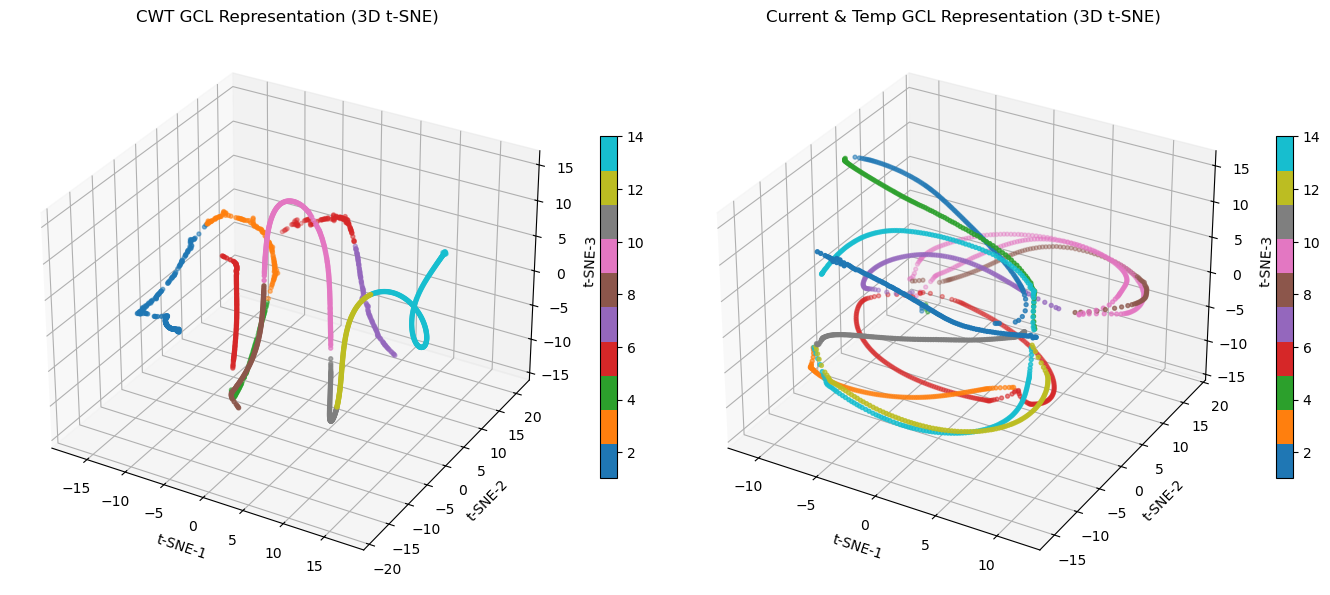

In [6]:
# ===================== 单cell：CWT / CT 两个模态 GCL 表征 3D 可视化 =====================
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --------------------- 1️⃣ 从 MMFD 加载图数据（train 集） ---------------------
MMFD_ROOT = "/home/charles/HZU/Data_processed/HSML/KAIST/MMFD"

cwt_graph = torch.load(f"{MMFD_ROOT}/cwt_train_graph.pt", map_location=device)
ct_graph  = torch.load(f"{MMFD_ROOT}/ct_train_graph.pt",  map_location=device)

# --------------------- 2️⃣ 封装成 PyG Data ---------------------
from torch_geometric.data import Data

def to_pyg_data(obj):
    return Data(
        x=obj["x"].to(device),
        edge_index=obj["edge_index"].to(device),
        y=obj["y"].to(device)
    )

cwt_data = to_pyg_data(cwt_graph)
ct_data  = to_pyg_data(ct_graph)

# --------------------- 3️⃣ 提取 encoder 表征 ---------------------
gcl_cwt.eval()
gcl_ct.eval()

with torch.no_grad():
    h_cwt, _ = gcl_cwt(cwt_data.x, cwt_data.edge_index)
    h_ct,  _ = gcl_ct(ct_data.x,  ct_data.edge_index)

h_cwt = h_cwt.cpu().numpy()
h_ct  = h_ct.cpu().numpy()

y_cwt = cwt_data.y.cpu().numpy()
y_ct  = ct_data.y.cpu().numpy()

print("CWT h shape:", h_cwt.shape)
print("CT  h shape:", h_ct.shape)

# --------------------- 4️⃣ t-SNE 降维（3D） ---------------------
tsne_cwt = TSNE(
    n_components=3,
    perplexity=30,
    learning_rate="auto",
    init="pca",
    random_state=42
)
z_cwt = tsne_cwt.fit_transform(h_cwt)

tsne_ct = TSNE(
    n_components=3,
    perplexity=30,
    learning_rate="auto",
    init="pca",
    random_state=42
)
z_ct = tsne_ct.fit_transform(h_ct)

# --------------------- 5️⃣ 3D 可视化 ---------------------
fig = plt.figure(figsize=(14, 6))

# ---- CWT ----
ax1 = fig.add_subplot(121, projection="3d")
p1 = ax1.scatter(
    z_cwt[:, 0], z_cwt[:, 1], z_cwt[:, 2],
    c=y_cwt, s=8, cmap="tab10"
)
ax1.set_title("CWT GCL Representation (3D t-SNE)")
ax1.set_xlabel("t-SNE-1")
ax1.set_ylabel("t-SNE-2")
ax1.set_zlabel("t-SNE-3")
fig.colorbar(p1, ax=ax1, shrink=0.6)

# ---- CT ----
ax2 = fig.add_subplot(122, projection="3d")
p2 = ax2.scatter(
    z_ct[:, 0], z_ct[:, 1], z_ct[:, 2],
    c=y_ct, s=8, cmap="tab10"
)
ax2.set_title("Current & Temp GCL Representation (3D t-SNE)")
ax2.set_xlabel("t-SNE-1")
ax2.set_ylabel("t-SNE-2")
ax2.set_zlabel("t-SNE-3")
fig.colorbar(p2, ax=ax2, shrink=0.6)

plt.tight_layout()
plt.show()


## 下游训练 

In [7]:
# ===================== 单cell：定义 train_data_cwt / val_data_cwt / train_data_ct / val_data_ct =====================
import torch
from torch_geometric.data import Data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MMFD_ROOT = "/home/charles/HZU/Data_processed/HSML/KAIST/MMFD"

def load_mmfd_graph(path):
    obj = torch.load(path, map_location="cpu")
    data = Data(
        x=obj["x"],
        edge_index=obj["edge_index"],
        y=obj["y"]
    )
    # 如果你之前保存了 edge_weight
    if "edge_weight" in obj:
        data.edge_attr = obj["edge_weight"].unsqueeze(-1)
    return data

# -------- CWT --------
train_data_cwt = load_mmfd_graph(f"{MMFD_ROOT}/cwt_train_graph.pt").to(device)
val_data_cwt   = load_mmfd_graph(f"{MMFD_ROOT}/cwt_val_graph.pt").to(device)

# -------- CT --------
train_data_ct  = load_mmfd_graph(f"{MMFD_ROOT}/ct_train_graph.pt").to(device)
val_data_ct    = load_mmfd_graph(f"{MMFD_ROOT}/ct_val_graph.pt").to(device)

print("✅ train/val Data objects ready")
print("CWT train:", train_data_cwt)
print("CWT val  :", val_data_cwt)
print("CT  train:", train_data_ct)
print("CT  val  :", val_data_ct)


✅ train/val Data objects ready
CWT train: Data(x=[1639, 125], edge_index=[2, 32720], y=[1639], edge_attr=[32720, 1])
CWT val  : Data(x=[272, 125], edge_index=[2, 5380], y=[272], edge_attr=[5380, 1])
CT  train: Data(x=[1639, 4], edge_index=[2, 32720], y=[1639], edge_attr=[32720, 1])
CT  val  : Data(x=[272, 4], edge_index=[2, 5380], y=[272], edge_attr=[5380, 1])


/tmp/ipykernel_58545/1532168892.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  obj = torch.load(path, map_location="cpu")


In [8]:
# ===================== 单cell：严格类间平衡的 train_withlabel_mask =====================
import torch
import numpy as np

def add_train_withlabel_mask_balanced(
    data,
    label_ratio=0.2,
    seed=42,
    min_per_class=1
):
    """
    严格类间平衡的标注 mask
    - 每个类别使用相同数量的标注样本
    - 标注数由最小类别决定
    """
    torch.manual_seed(seed)
    np.random.seed(seed)

    y = data.y.cpu().numpy()
    num_nodes = len(y)

    mask = torch.zeros(num_nodes, dtype=torch.bool)

    classes = np.unique(y)
    class_indices = {c: np.where(y == c)[0] for c in classes}

    # ① 计算每类最大可用标注数
    min_class_size = min(len(idx) for idx in class_indices.values())

    # ② 实际使用的每类标注数
    num_labeled_per_class = max(
        min_per_class,
        int(min_class_size * label_ratio)
    )

    print(f"📌 Using {num_labeled_per_class} labeled samples per class")

    # ③ 对每个类别均匀采样
    for cls, idx in class_indices.items():
        idx = idx.copy()
        np.random.shuffle(idx)
        selected = idx[:num_labeled_per_class]
        mask[selected] = True

    data.train_withlabel_mask = mask.to(data.x.device)
    return data


# ===================== 使用示例 =====================
label_ratio = 0.2  # 表示“最小类的 20%”

train_data_cwt = add_train_withlabel_mask_balanced(
    train_data_cwt,
    label_ratio=label_ratio,
    seed=42
)

train_data_ct = add_train_withlabel_mask_balanced(
    train_data_ct,
    label_ratio=label_ratio,
    seed=42
)

print("✅ Balanced train_withlabel_mask added")

# ===================== 自检：每类标注数 =====================
def check_mask_balance(data, name):
    y = data.y
    mask = data.train_withlabel_mask
    print(f"\n[{name}] labeled samples per class:")
    for cls in torch.unique(y):
        cnt = ((y == cls) & mask).sum().item()
        print(f"  class {cls.item():2d}: {cnt}")

check_mask_balance(train_data_cwt, "CWT")
check_mask_balance(train_data_ct,  "CT")


📌 Using 23 labeled samples per class
📌 Using 23 labeled samples per class
✅ Balanced train_withlabel_mask added

[CWT] labeled samples per class:
  class  1: 23
  class  2: 23
  class  3: 23
  class  4: 23
  class  5: 23
  class  6: 23
  class  7: 23
  class  8: 23
  class  9: 23
  class 10: 23
  class 11: 23
  class 12: 23
  class 13: 23
  class 14: 23

[CT] labeled samples per class:
  class  1: 23
  class  2: 23
  class  3: 23
  class  4: 23
  class  5: 23
  class  6: 23
  class  7: 23
  class  8: 23
  class  9: 23
  class 10: 23
  class 11: 23
  class 12: 23
  class 13: 23
  class 14: 23


In [10]:
# ======================================================================
# ⭐ 单 Cell：CWT / CT 两个 embedding 独立的下游分类训练（含 val 验证）⭐
# ======================================================================
%run ../_init_path.py
from models import DownstreamKANClassifier

import torch
import torch.nn.functional as F
from torch.optim import Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ======================================================================
# 0️⃣ 工具函数
# ======================================================================
def l2_normalize(h, eps=1e-8):
    return h / (h.norm(dim=1, keepdim=True) + eps)


def train_downstream_single_modal(
    name,
    gcl_model,
    train_data,
    val_data,
    save_path
):
    print(f"\n================ 🚀 下游分类训练：{name} =================\n")

    # ---- 准备 ----
    train_data = train_data.to(device)
    val_data   = val_data.to(device)

    gcl_model = gcl_model.to(device)
    gcl_model.eval()

    # ==================================================================
    # 1️⃣ 提取 encoder 表征
    # ==================================================================
    with torch.no_grad():
        h_train, _ = gcl_model(train_data.x, train_data.edge_index)
        h_val,   _ = gcl_model(val_data.x,   val_data.edge_index)

    h_train = l2_normalize(h_train.detach())
    h_val   = l2_normalize(h_val.detach())

    # ---- train mask ----
    y_train = train_data.y
    mask_train = train_data.train_withlabel_mask
    idx_train = mask_train.nonzero(as_tuple=False).view(-1)

    h_train_labeled = h_train[idx_train]
    y_train_labeled = y_train[idx_train]

    # ---- val ----
    y_val = val_data.y

    print(f"📌 [{name}] Train labeled samples: {h_train_labeled.shape[0]}")
    print(f"📌 [{name}] Embedding dim: {h_train_labeled.shape[1]}")

    # ==================================================================
    # 2️⃣ 定义分类器
    # ==================================================================
    num_features = h_train_labeled.size(1)
    num_classes = int(max(y_train_labeled.max(), y_val.max()).item() + 1)

    classifier = DownstreamKANClassifier(
        in_dim=num_features,
        num_classes=num_classes,
        hidden_dim=128,
        num_knots=8
    ).to(device)

    optimizer = Adam(classifier.parameters(), lr=1e-3, weight_decay=1e-4)

    # ==================================================================
    # 3️⃣ 训练 + 验证
    # ==================================================================
    epochs = 500
    best_val_acc = 0.0
    best_state = None

    for epoch in range(1, epochs + 1):

        # ---- Train ----
        classifier.train()
        optimizer.zero_grad()

        logits_train = classifier(h_train_labeled)
        loss = F.cross_entropy(logits_train, y_train_labeled)
        loss.backward()
        optimizer.step()

        # ---- Val ----
        classifier.eval()
        with torch.no_grad():
            logits_val = classifier(h_val)
            pred_val = logits_val.argmax(dim=1)
            acc_val = (pred_val == y_val).float().mean().item()

        if epoch % 5 == 0:
            print(
                f"[{name}] Epoch {epoch:03d}/{epochs} | "
                f"Train Loss = {loss.item():.4f} | Val Acc = {acc_val*100:.2f}%"
            )

        if acc_val > best_val_acc:
            best_val_acc = acc_val
            best_state = {
                "state_dict": classifier.state_dict(),
                "in_dim": num_features,
                "num_classes": num_classes
            }

    # ==================================================================
    # 4️⃣ 保存最优模型
    # ==================================================================
    torch.save(best_state, save_path)

    print(f"\n🏁 [{name}] 训练完成")
    print(f"🌟 [{name}] 最佳 Val Acc：{best_val_acc*100:.2f}%")
    print(f"💾 [{name}] 最优模型已保存：{save_path}")


# ======================================================================
# 4️⃣ 分别训练两个 embedding 的下游分类器
# ======================================================================

# ---- CWT ----
train_downstream_single_modal(
    name="CWT",
    gcl_model=gcl_cwt,
    train_data=train_data_cwt,
    val_data=val_data_cwt,
    save_path="/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/MMFD/KAIST_CWT/model_save/time_CWT/MMFD/downstream/downstream_CWT_classifier_val_best.pt"
)

# ---- CT ----
train_downstream_single_modal(
    name="CT",
    gcl_model=gcl_ct,
    train_data=train_data_ct,
    val_data=val_data_ct,
    save_path="/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/MMFD/KAIST_CWT/model_save/time_CWT/MMFD/downstream/downstream_CT_classifier_val_best.pt"
)


✅ 已添加路径：/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/MMFD/KAIST_CWT
✅ 已添加 my_lib：/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/MMFD/KAIST_CWT/src

================ 🚀 下游分类训练：CWT =================

📌 [CWT] Train labeled samples: 322
📌 [CWT] Embedding dim: 128
[CWT] Epoch 005/500 | Train Loss = 2.6437 | Val Acc = 6.99%
[CWT] Epoch 010/500 | Train Loss = 2.5958 | Val Acc = 9.19%
[CWT] Epoch 015/500 | Train Loss = 2.5021 | Val Acc = 14.71%
[CWT] Epoch 020/500 | Train Loss = 2.3585 | Val Acc = 14.34%
[CWT] Epoch 025/500 | Train Loss = 2.1997 | Val Acc = 7.35%
[CWT] Epoch 030/500 | Train Loss = 2.0529 | Val Acc = 14.71%
[CWT] Epoch 035/500 | Train Loss = 1.9288 | Val Acc = 7.35%
[CWT] Epoch 040/500 | Train Loss = 1.8348 | Val Acc = 14.34%
[CWT] Epoch 045/500 | Train Loss = 1.7583 | Val Acc = 7.35%
[CWT] Epoch 050/500 | Train Loss = 1.6995 | Val Acc = 7.35%
[CWT] Epoch 055/500 | Train Loss = 1.6504 | Val Acc = 7.35%
[

In [11]:
# ======================================================================
# ⭐ 单 Cell：统计 CWT / CT 的混淆矩阵 & 混淆最严重的类别 ⭐
# ======================================================================
import torch
import numpy as np
from sklearn.metrics import confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def confusion_analysis(
    name,
    gcl_model,
    classifier_state,
    data,
    top_k=5
):
    """
    在 val_data 上统计混淆矩阵，并输出混淆最严重的类别对
    """
    print(f"\n================ 📊 混淆分析：{name} =================")

    data = data.to(device)
    gcl_model.eval()

    # -------- 1️⃣ 提取 embedding --------
    with torch.no_grad():
        h, _ = gcl_model(data.x, data.edge_index)
        h = h / (h.norm(dim=1, keepdim=True) + 1e-8)

    # -------- 2️⃣ 加载分类器 --------
    classifier = DownstreamKANClassifier(
        in_dim=classifier_state["in_dim"],
        num_classes=classifier_state["num_classes"],
        hidden_dim=128,
        num_knots=8
    ).to(device)
    classifier.load_state_dict(classifier_state["state_dict"])
    classifier.eval()

    # -------- 3️⃣ 推理 --------
    with torch.no_grad():
        logits = classifier(h)
        y_pred = logits.argmax(dim=1).cpu().numpy()

    y_true = data.y.cpu().numpy()

    # -------- 4️⃣ 混淆矩阵 --------
    cm = confusion_matrix(y_true, y_pred)
    num_classes = cm.shape[0]

    print(f"\n混淆矩阵 (shape={cm.shape}):")
    print(cm)

    # -------- 5️⃣ 统计混淆最严重的类别对 --------
    confusion_pairs = []

    for i in range(num_classes):
        for j in range(num_classes):
            if i != j and cm[i, j] > 0:
                confusion_pairs.append((i, j, cm[i, j]))

    confusion_pairs.sort(key=lambda x: x[2], reverse=True)

    print(f"\n🔥 Top-{top_k} 混淆最严重的类别对 (true → pred):")
    for i, j, cnt in confusion_pairs[:top_k]:
        print(f"  Class {i} → Class {j}: {cnt} samples")

    # -------- 6️⃣ 每类准确率 --------
    print("\n📌 Per-class accuracy:")
    for i in range(num_classes):
        total = cm[i].sum()
        acc_i = cm[i, i] / total if total > 0 else 0.0
        print(f"  Class {i}: {acc_i*100:.2f}%")

    return cm


# ======================================================================
# 读取你刚才保存的最优分类器
# ======================================================================
cwt_state = torch.load(
    "/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/"
    "my_CIL_V1/MMFD/KAIST_CWT/model_save/time_CWT/MMFD/downstream/"
    "downstream_CWT_classifier_val_best.pt",
    map_location=device
)

ct_state = torch.load(
    "/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/"
    "my_CIL_V1/MMFD/KAIST_CWT/model_save/time_CWT/MMFD/downstream/"
    "downstream_CT_classifier_val_best.pt",
    map_location=device
)

# ======================================================================
# CWT / CT 分别做混淆分析
# ======================================================================
cm_cwt = confusion_analysis(
    name="CWT",
    gcl_model=gcl_cwt,
    classifier_state=cwt_state,
    data=val_data_cwt,
    top_k=10
)

cm_ct = confusion_analysis(
    name="CT",
    gcl_model=gcl_ct,
    classifier_state=ct_state,
    data=val_data_ct,
    top_k=10
)



================ 📊 混淆分析：CWT =================

混淆矩阵 (shape=(14, 14)):
[[19  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [20  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [20  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [19  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 19  0  0  0  0  0  0  0  0  0  0  0  0]
 [18  2  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2 17  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  1  2  8  1  6  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 17  2  0  0  0  0  0  0  0]
 [ 0  0  0 12  0  5  2  0  0  0  0  0  0  0]
 [ 0  0  0  0 19  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  6  0  0  0  0 14  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 19  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 19  0  0  0  0]]

🔥 Top-10 混淆最严重的类别对 (true → pred):
  Class 1 → Class 0: 20 samples
  Class 2 → Class 0: 20 samples
  Class 3 → Class 0: 19 samples
  Class 4 → Class 1: 19 samples
  Class 10 → Class 4: 19 samples
  Class 12 → Class 9: 19 samples
  Class 13 → Class 9: 19 samples
  Class 5 → Class 0: 18 samples
  Cl

/tmp/ipykernel_58545/3837700065.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cwt_state = torch.load(
/tmp/ipykernel_58545/3837700065.py:89: FutureWarning: You are us

## 最终acc测试